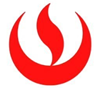

<h3 align="center">Inteligencia Artificial - WS7A</h3>

## (3) Redes Recurrentes Hopfield - Reconocimiento de patrones en imágenes

In [64]:
import os
import numpy as np
import imageio
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [65]:
# Instalamos OpenCV para el tratamiento de imagenes
# pip install opencv-python
# conda install opencv
import cv2
# Comprobamos la instalacion
print (cv2.__version__)

4.5.1


In [66]:
# Cargamos la imagen con un canal de color de 3 colores
img = cv2.imread('deal-with-it-with-text3.jpg', cv2.IMREAD_COLOR) 
print("Shape de la imagen cargada es:", img.shape)

Shape de la imagen cargada es: (128, 128, 3)


In [67]:
# Cargamos la imagen con un canal de color de 2 colores
img = cv2.imread('deal-with-it-with-text3.jpg', cv2.IMREAD_GRAYSCALE) 
print("Shape de la imagen cargada es:", img.shape)

Shape de la imagen cargada es: (128, 128)


In [68]:
# Convertimos la imagen a un arreglo de enteros
img = img.astype(int)

In [69]:
np.unique(img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  55,  56,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

Para convertir esto en una imagen de 1 bit, convierto todo lo más oscuro que algún umbral a negro (1) y todo lo demás a blanco (-1). Experimentando un poco con la imagen particular del 'meme de lidiar con eso' que tengo, un umbral de 80 parecía funcionar razonablemente. La imagen resultante todavía es un poco tosca en los bordes, pero es reconocible.

In [70]:
bvw_threshold = 80

img[img <= bvw_threshold] = -1
img[img >  bvw_threshold] = 1
img = -img
img

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [71]:
np.unique(img)

array([-1,  1])

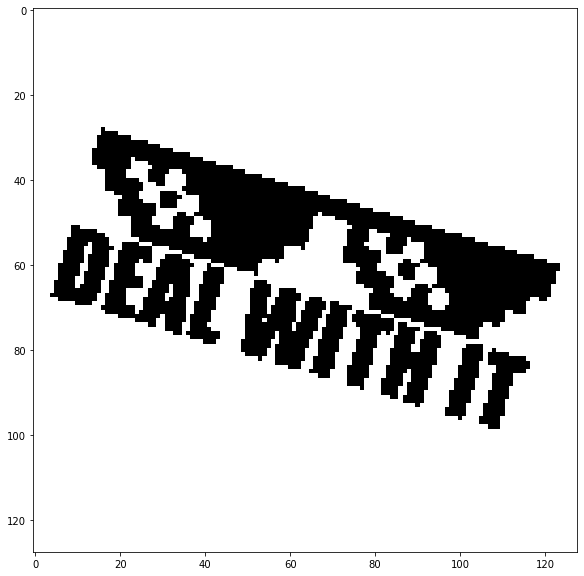

In [72]:
plt.imshow(img, cmap='Greys', interpolation='nearest')
plt.show()

Ahora calcularemos los pesos. Por ahora, usaremos la regla de aprendizaje de Hebb, según la cual dos unidades tienen un peso positivo (+1) si su activación es la misma, y un peso negativo (-1) si sus activaciones son diferentes. También estipulamos que una neurona no tiene peso consigo misma.

In [73]:
flattened_img = img.flatten()
flattened_img.shape

(16384,)

Esta siguiente celda puede tardar un poco si la imagen es grande ...

In [74]:
flatlen = len(flattened_img)

img_weights = np.outer(flattened_img,flattened_img) - np.identity(len(flattened_img))
img_weights[:5,:5]

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

Ahora comience con una versión ruidosa de la imagen. Simplemente voltearemos una cierta cantidad de píxeles aleatorios en cada fila de la imagen.

In [75]:
def noisify(pattern, numb_flipped=30):

    noisy_pattern = pattern.copy()

    for idx, row in enumerate(noisy_pattern):
        choices = np.random.choice(range(len(row)), numb_flipped)
        noisy_pattern[idx,choices] = -noisy_pattern[idx,choices]
        
    return noisy_pattern

noisy_img = noisify(pattern=img)

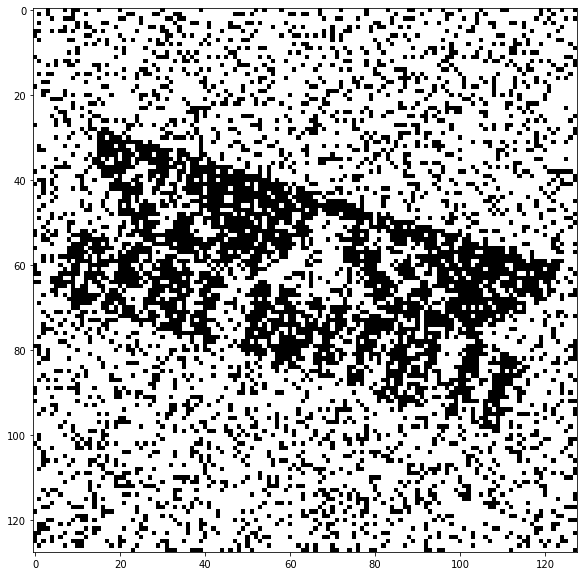

In [76]:
plt.imshow(noisy_img, cmap='Greys', interpolation='nearest')
plt.show()

Ahora podemos comenzar con eso y usar los pesos para actualizarlo. Actualizaremos las unidades de forma asincrónica (una a la vez).

Mientras actualizamos las unidades, hagamos un seguimiento de la energía en la red:

La actualización de las activaciones de las unidades hace que la red se mueva hacia un mínimo local en esa función. Dicho de manera más informal, la actualización de las unidades pone a la red en un estado más "relajado".

Matemática de matriz numérica eficiente para calcular la energía extraída de aquí: https://codeaffectionate.blogspot.com/2013/05/fun-with-hopfield-and-numpy.html

In [77]:
def flow(pattern, weights, theta=0, steps = 50000):
    
    pattern_flat = pattern.flatten()
    
    if (type(theta) == float) or (type(theta) == int):
        thetas = np.zeros(len(pattern_flat)) + theta

    for step in range(steps):
        unit = np.random.randint(low=0, high=(len(pattern_flat)-1))
        unit_weights = weights[unit,:]
        net_input = np.dot(unit_weights,pattern_flat)
        pattern_flat[unit] = 1 if (net_input > thetas[unit]) else -1
        
        if (step % 10000) == 0:
            energy = -0.5*np.dot(np.dot(pattern_flat.T,weights),pattern_flat) + np.dot(thetas,pattern_flat)
            print("Energy at step {:05d} is now {}".format(step,energy))
            
    evolved_pattern = np.reshape(a=pattern_flat, newshape=(pattern.shape[0],pattern.shape[1]))
    
    return evolved_pattern

In [78]:
steps = 50000
theta = 0

noisy_img_evolved = flow(noisy_img, img_weights, theta = theta, steps = steps)

Energy at step 00000 is now -45059826.0
Energy at step 10000 is now -80636808.0
Energy at step 20000 is now -102752256.0
Energy at step 30000 is now -115876896.0
Energy at step 40000 is now -124306720.0


Como era de esperar, la energía disminuye a medida que se actualizan las activaciones de las unidades. Ahora visualicemos el patrón "evolucionado".

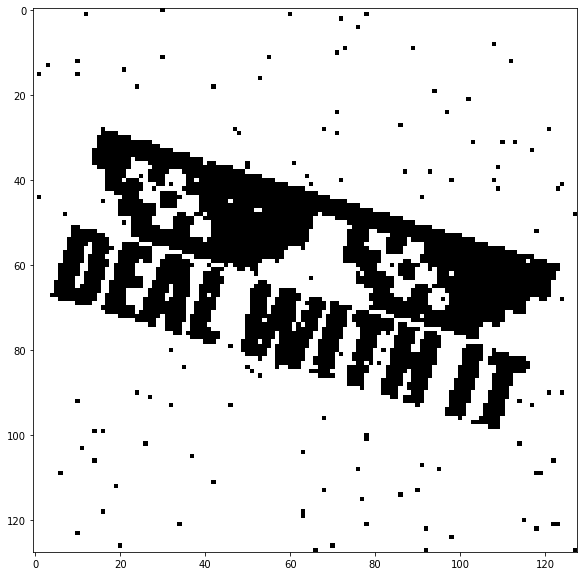

In [79]:
plt.imshow(noisy_img_evolved, cmap='Greys', interpolation='nearest')
plt.show()

**Buen trabajo!.**
Ahora probar este código con otra imagen.